# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

<img src='notebook_ims/vgg19_convlayers.png' width=80% />

In [20]:
!wget "http://cdn.masterstudies.com/element_db/37/3737_NUS-ISS.jpg" -O "./images/iss.jpg"

!wget "https://deepart-io.s3.amazonaws.com/img/style.jpg" -O "images/style.jpg"

--2018-11-23 20:17:17--  http://cdn.masterstudies.com/element_db/37/3737_NUS-ISS.jpg
Resolving cdn.masterstudies.com (cdn.masterstudies.com)... 205.185.216.10, 205.185.216.42
Connecting to cdn.masterstudies.com (cdn.masterstudies.com)|205.185.216.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238902 (233K) [image/jpeg]
Saving to: ‘./images/iss.jpg’

./images/iss.jpg    100%[===================>] 233.30K  --.-KB/s    in 0.007s  

2018-11-23 20:17:17 (30.6 MB/s) - ‘./images/iss.jpg’ saved [238902/238902]

--2018-11-23 20:17:17--  https://deepart-io.s3.amazonaws.com/img/style.jpg
Resolving deepart-io.s3.amazonaws.com (deepart-io.s3.amazonaws.com)... 52.218.84.233
Connecting to deepart-io.s3.amazonaws.com (deepart-io.s3.amazonaws.com)|52.218.84.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60111 (59K) [image/jpeg]
Saving to: ‘images/style.jpg’

images/style.jpg    100%[===================>]  58.70K  34.4KB/s    in 1.7s    

2018-

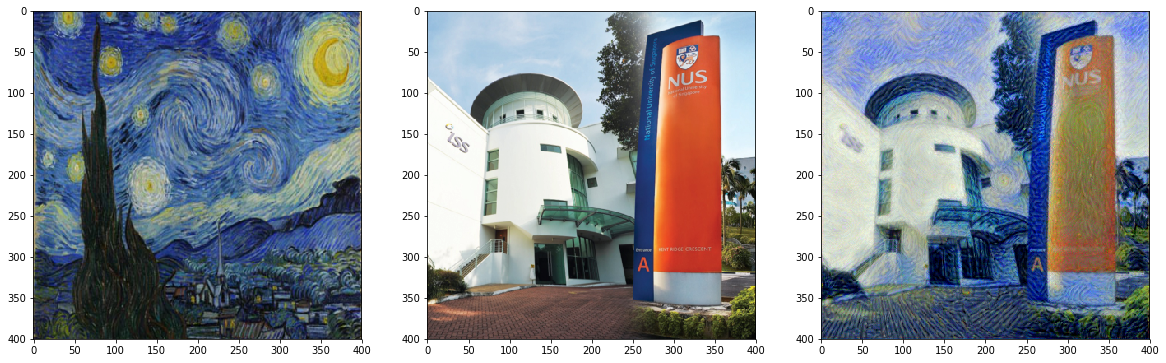

In [22]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models




########
target_img_path = 'images/iss.jpg'
style_img_path = 'images/style.jpg'


###########
# UTIL FUNC
###########

def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)    
    return image


# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image


def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '28': 'conv5_1',
            '21': 'conv4_2',
            '30': 'conv5_2'
        }
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    _ , d, h , w = tensor.size()
    FeatureVec = tensor.view(  d, h*w)
    gram = torch.mm( FeatureVec , FeatureVec.t() )
    return gram 

# **** MAIN PROGRAM ****

# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LOAD THE INPUT IMAGES:
# load in content and style image
content = load_image(target_img_path).to(device)
# Resize style to match content, makes code easier
style = load_image(style_img_path, shape=content.shape[-2:]).to(device)

# SHOW IMAGES

# display the images
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
#ax1.imshow(im_convert(content))
#ax2.imshow(im_convert(style))


# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)


# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)


# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta


# STYLE TRANSFER OPTOMIZATION CODE - Just Adam optimizer, minimizing those two loses (combined)

# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    target_features = get_features( target , vgg )
    content_loss = torch.mean( (target_features['conv5_2'] -  content_features["conv5_2"])**2 )
    
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        target_feature_V = target_feature.view(d, h*w)
        target_gram = torch.mm( target_feature_V , target_feature_V.t() )
        
        style_gram = style_grams[layer]
        
        ## Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean( (target_gram - style_gram)**2 )
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
        
    ## calculate the *total* loss
    total_loss = (content_weight * content_loss) + (style_weight * style_loss)
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    #     if  ii % show_every == 0:
    #         print('Total loss: ', total_loss.item())
    #         plt.imshow(im_convert(target))
    #         plt.show()
        
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(style))
ax2.imshow(im_convert(content))
ax3.imshow(im_convert(target))

fig.save("./out/output.jpg")